## 🔧 Step 1: Install Mantis

We begin by installing the `mantis` package directly from GitHub. This will download the latest version of the code and install all required dependencies.

In [1]:
# Clone the full Mantis repository and move into it
!git clone https://github.com/carsondudley1/Mantis.git
%cd Mantis

# Install the package in editable mode
!pip install -e .

Cloning into 'Mantis'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 61 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 57.16 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/Mantis
Obtaining file:///content/Mantis
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mantis


## 📦 Step 2: Download the Pretrained Model

Mantis uses pretrained simulation-grounded foundation models for forecasting.  
In this tutorial, we’ll use the **4-week horizon model with covariates**.

This cell downloads the model file (~1 GB) from the [GitHub release](https://github.com/carsondudley1/Mantis/releases/tag/mantis-v1.0) and places it in a local `models/` directory.

In [2]:
# Download the 4-week model that takes covariates

!mkdir -p models
!wget -O models/mantis_4w_cov.pt https://github.com/carsondudley1/Mantis/releases/download/mantis-v1.0/mantis_4w_cov.pt

--2025-08-06 21:22:03--  https://github.com/carsondudley1/Mantis/releases/download/mantis-v1.0/mantis_4w_cov.pt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/1028419690/2f95c870-6a12-4737-a6f9-a9332d52ae01?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-06T22%3A21%3A37Z&rscd=attachment%3B+filename%3Dmantis_4w_cov.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-06T21%3A20%3A59Z&ske=2025-08-06T22%3A21%3A37Z&sks=b&skv=2018-11-09&sig=xMECsG319N4Vw%2FCKKwrhoMtXk2wOEEZ7Z5oSAJBE4kY%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NDUxNTYyNCwibmJmIjoxNzU0NTE1MzI0LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZ

## 📊 Step 3: Import Mantis and Load Example Data

We now import the `Mantis` model and load example COVID-19 hospitalization data.  
This dataset includes daily hospitalization counts for all 50 U.S. states, Washington DC, and Puerto Rico, with columns labeled by state abbreviation (e.g., `ca`, `ny`, `tx`).

We'll extract the weekly time series for a single state and use that as our forecasting input.  
Since we're doing this at the University of Michigan, we'll use Michigan. (_**Go Blue!**_ 💙💛)

In [19]:
# Import Mantis and supporting libraries
from mantis import Mantis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load COVID-19 hospitalizations and deaths datasets
hosp_df = pd.read_csv("data/covid_hospitalizations.csv")
deaths_df = pd.read_csv("data/covid_deaths.csv")

# Choose the state of Michigan (Go Blue!)
state = "mi"
hosp_ts = hosp_df[state].values         # target time series
deaths_ts = deaths_df[state].values     # covariate time series

## 🤖 Step 4: Initialize Mantis and Generate a Forecast

We now create an instance of the Mantis model — specifically, the 4-week horizon version with covariates.  
Then we pass in Michigan's hospitalization and death time series to generate forecasts.

Mantis returns 9 quantiles for each of the next 4 weeks, providing a full probabilistic forecast.


In [20]:
# Initialize Mantis (4-week horizon, with covariates)
model = Mantis(forecast_horizon=4, use_covariate=True)

# Forecast points in weeks
forecast_weeks = [20, 25, 30, 35, 40, 45, 50, 55]

# Storage
forecasts = []
ground_truths = []
start_weeks = []

for week in forecast_weeks:
    if week + 4 > len(hosp_ts):
        print(f"Skipping week {week}: not enough future data.")
        continue

    # Input = data up to current week
    input_target = deaths_ts[:week]
    input_cov = hosp_ts[:week]
    true_future = deaths_ts[week:week + 4]

    pred = model.predict(
        time_series=input_target,
        covariate=input_cov,
        target_type=2,
        covariate_type=1
    )

    forecasts.append(pred)
    ground_truths.append(true_future)
    start_weeks.append(week)

## 📈 Step 5: Plot All Forecasts with Historical Context

We now visualize all of the forecasts on a **single plot**, along with the **20 weeks of historical context** leading up to the first forecast.

Each forecast includes:
- The 50% quantile (solid line)
- The 90% confidence interval (shaded area)
- Ground truth values (black line)

This provides a realistic view of how Mantis forecasts evolve over time.

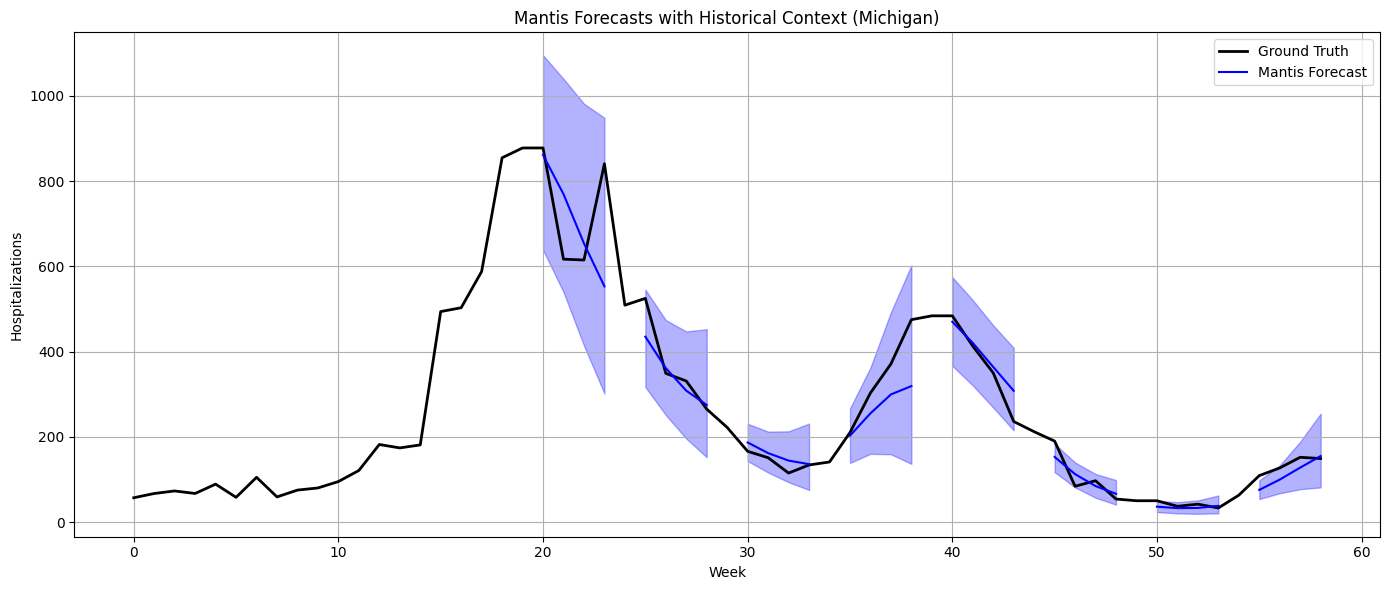

In [22]:
# Weeks of historical context before the first forecast
history_weeks = 20
first_week = start_weeks[0]
start_plot = max(0, first_week - history_weeks)
end_plot = start_weeks[-1] + 4  # last forecast + 4 weeks

# Slice the ground truth time series
weeks = np.arange(start_plot, end_plot)
truth_slice = deaths_ts[start_plot:end_plot]

# Plot setup
plt.figure(figsize=(14, 6))
plt.plot(weeks, truth_slice, "k-", label="Ground Truth", linewidth=2)

# Forecast color (consistent across all forecast launches)
forecast_color = "blue"
plotted_forecast_label = False

# Add forecasts
for i, (forecast, start) in enumerate(zip(forecasts, start_weeks)):
    pred_weeks = np.arange(start, start + 4)
    median = forecast[:, 4]
    lower = forecast[:, 0]
    upper = forecast[:, 8]

    # Only add label to the first one
    label = "Mantis Forecast" if not plotted_forecast_label else None
    plotted_forecast_label = True

    plt.plot(pred_weeks, median, color=forecast_color, label=label)
    plt.fill_between(pred_weeks, lower, upper, color=forecast_color, alpha=0.3)

# Plot settings
plt.title("Mantis Forecasts with Historical Context (Michigan)")
plt.xlabel("Week")
plt.ylabel("Hospitalizations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()